# Entrenamiento de una Red Neoronal (Perceptron)

```
Autor       : Francisco Jimenez Mucho
Linkedin    : https://www.linkedin.com/in/fjmucho/
date        : 2024, uppdate julio 2025
```

## Viga simplemente apoyada

In [34]:
import numpy as np, pandas as pd

from matplotlib import pyplot as plt

In [35]:
m = 1

cm = 0.01*m
kg = 1.0
kN = 1000.0*kg/m

### 🟢 1. Introduccion

En este ejemplo se requiere predecir la **deflexión máxima** de una viga **simplemente apoyada con carga puntual centrada**

$$\sigma_{máx} = \frac{PL^3}{48EI}$$
donde:
- P: Carga puntual en el centro (kN)
- L:m Lognitud de la viga (m)
- E: Módulo de elasticidad ($kN/m^2$)
- I: Momento de inercia ($\frac{bh^3}{12}$)

Para solucionar usaremos 2 puntos de vista.
- Un **modelo de Machin Learning** (random forest Regresion)
- Formulacion clásica o Modelo Matemático de mecánica de materailes.

In [36]:
print("\nRectangular Beam\n")
print("   Width\n ________\n|        |\n|        |\n|        |\n|        | Depth\n|        |\n|        |\n|        |\n|________|\n")

print('\n\t\tP\t\t\n|_______________↓_______________|\n|\t\tL\t\t|') # ↓ = \u2193


Rectangular Beam

   Width
 ________
|        |
|        |
|        |
|        | Depth
|        |
|        |
|        |
|________|


		P		
|_______________↓_______________|
|		L		|


In [37]:
def gen_value_viga_simple(num_muestras = 10_000, random_sate=50):
    np.random.seed(random_sate)

    # Módulos de elasticidad para diferentes resistencias a la compresión del hormigón (fc) en MPa
    modulo_elasticidad = {
        175: 19_663_000,
        210: 21_541_000,
        280: 24_870_000,
        350: 27_805_000,
        420: 30_463_000,
    }
    claves_fc = list(modulo_elasticidad.keys())
    valores_E = list(modulo_elasticidad.values())

    # Longitudes entre 2 y 10 m, con incrementos de 0.05 m y ancho y altura entre 0.25 y 0.60 m y 0.30 y 1.00 m respectivamente
    longitud = np.round( np.random.uniform(2, 10, num_muestras)/0.05 ) * 0.05 # [m]
    ancho_b = np.round( np.random.uniform(0.25, 0.60, num_muestras)/0.05 ) * 0.05 # [m]
    altura_h = np.round( np.random.uniform(0.30, 1.00, num_muestras)/0.05 ) * 0.05 # [m]

    # Cargas aleatorias entre 10 y 100 kN
    cargasP = np.round(np.random.uniform(10, 100, num_muestras), 2) # [kN]

    idx_modulo_elasticidad = np.random.randint(0, len(valores_E), num_muestras)
    fc_values = [claves_fc[i] for i in idx_modulo_elasticidad]
    e_values = [valores_E[i] for i in idx_modulo_elasticidad]

    inercia_vals = (ancho_b * altura_h**3) / 12.0  # [m^4]

    idelta_vals = (cargasP*longitud**3) / (48 * np.array(e_values) * inercia_vals)

    data = pd.DataFrame({
        'L': longitud,  # [m]
        'b': ancho_b,  # [m]
        'h': altura_h,  # [m]
        'P': cargasP,  # [kN]
        'fc': fc_values,  # [MPa]
        'E': e_values,  # [MPa]
        "I": inercia_vals,  # [m^4]
        "deflexion_max_mm": idelta_vals*1000,  # [mm]
    })
    data.to_csv('outputs/parametros_viga_simplemente_apoyada.csv', index=True)

    return data

In [38]:
data = gen_value_viga_simple(15_000)
data.head(6)

,L,b,h,P,fc,E,I,deflexion_max_mm
0,5.95,0.60,0.55,46.92,350,27805000,0.008319,0.890198
1,3.80,0.55,0.35,89.06,175,19663000,0.001965,2.634856
2,4.05,0.35,0.85,44.18,420,30463000,0.017912,0.112056
3,5.15,0.40,0.60,20.11,175,19663000,0.007200,0.404213
4,5.00,0.40,0.95,15.03,420,30463000,0.028579,0.044958
5,9.95,0.60,0.75,26.22,350,27805000,0.021094,0.917453


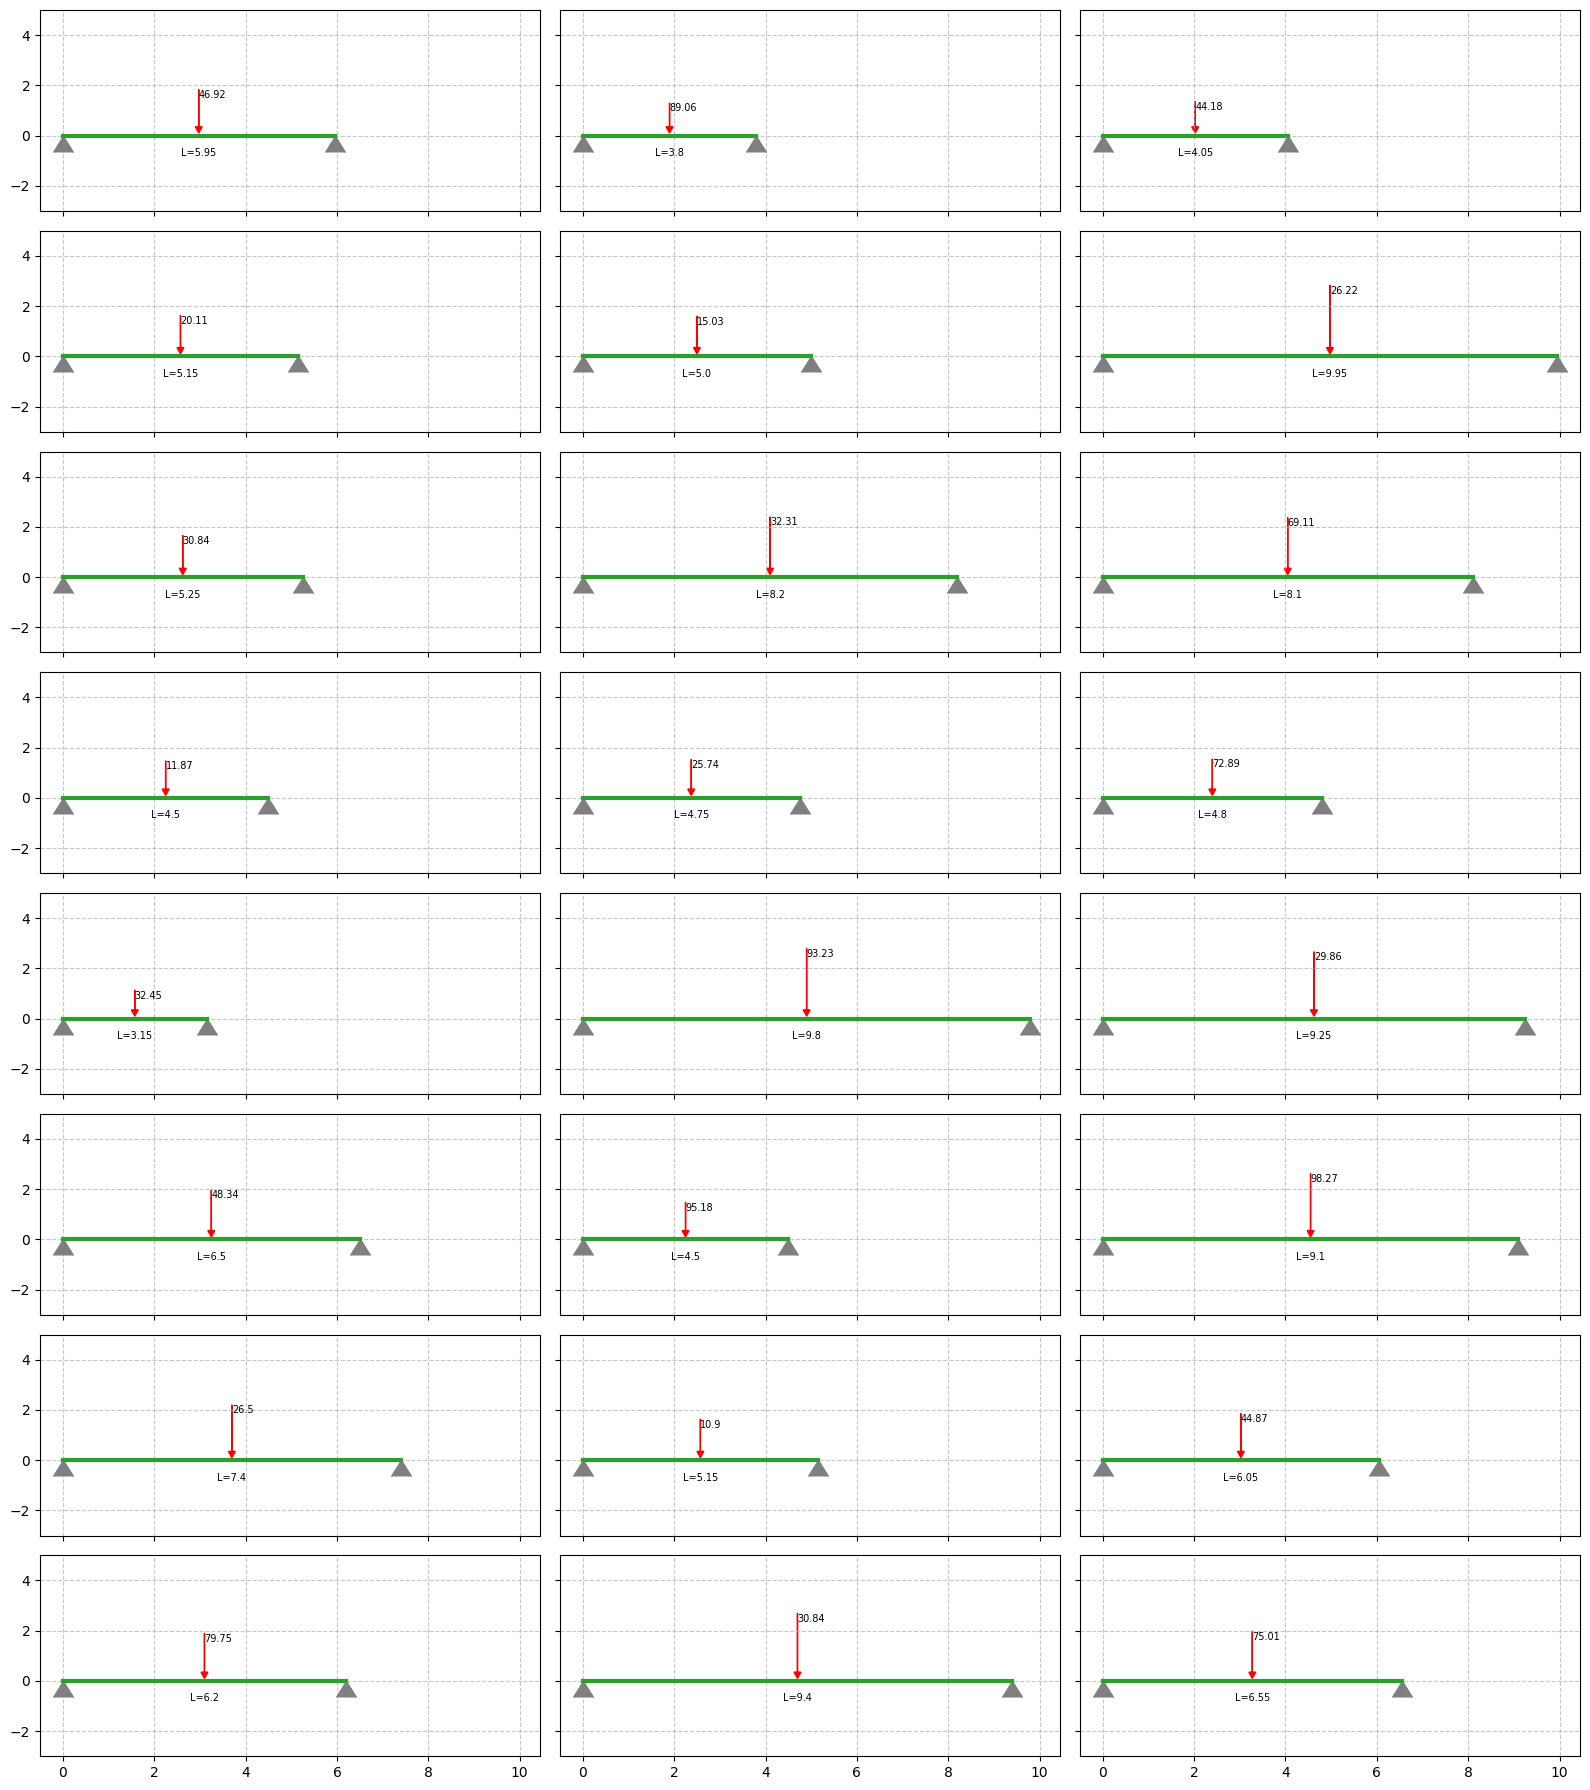

In [39]:
num_data = len(data['L'].head(24)) # debe ser multiplo de 3
fig, axes = plt.subplots(int(num_data/3), 3, figsize=(16, 18), sharex=True, sharey=True) # debe ser multiplo de 3 las filas y columnas
axs = axes.flatten() # lo convierte en una lista unidimensional
# fig.suptitle(f"Seccion de las vigas para {len(data)} muestras")
for i in range(num_data):
    L = data['L'][i].item()
    axs[i].plot([0, L], [0,0], marker=6, color='tab:gray', ms=15)   # restricciones
    axs[i].plot([0, L], [0,0], color='tab:green', lw=3)             # arista o viga
    axs[i].arrow(
        L/2,         # x: mitad de la viga
        0.35 + (L/4 + 0.0001),  # y: parte superior de la flecha
        0, -(L/4 + 0.0001), # dy NEGATIVO: apunta hacia abajo
        head_width=0.15,
        head_length=0.25,
        fc='red',
        ec='red'
    )
    axs[i].text( L/2, (L/4 + 0.01), str(round(data['P'][i].item(), 2)), ha='left', va='baseline', fontsize=7)
    axs[i].text(L/2, -0.5, 'L='+str(round(L,3)), color='k', ha='center', va='top', fontsize=7)
    # axs[i].axis('on')
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)
    axs[i].set_ylim([-3, 5])
plt.tight_layout()
plt.show()

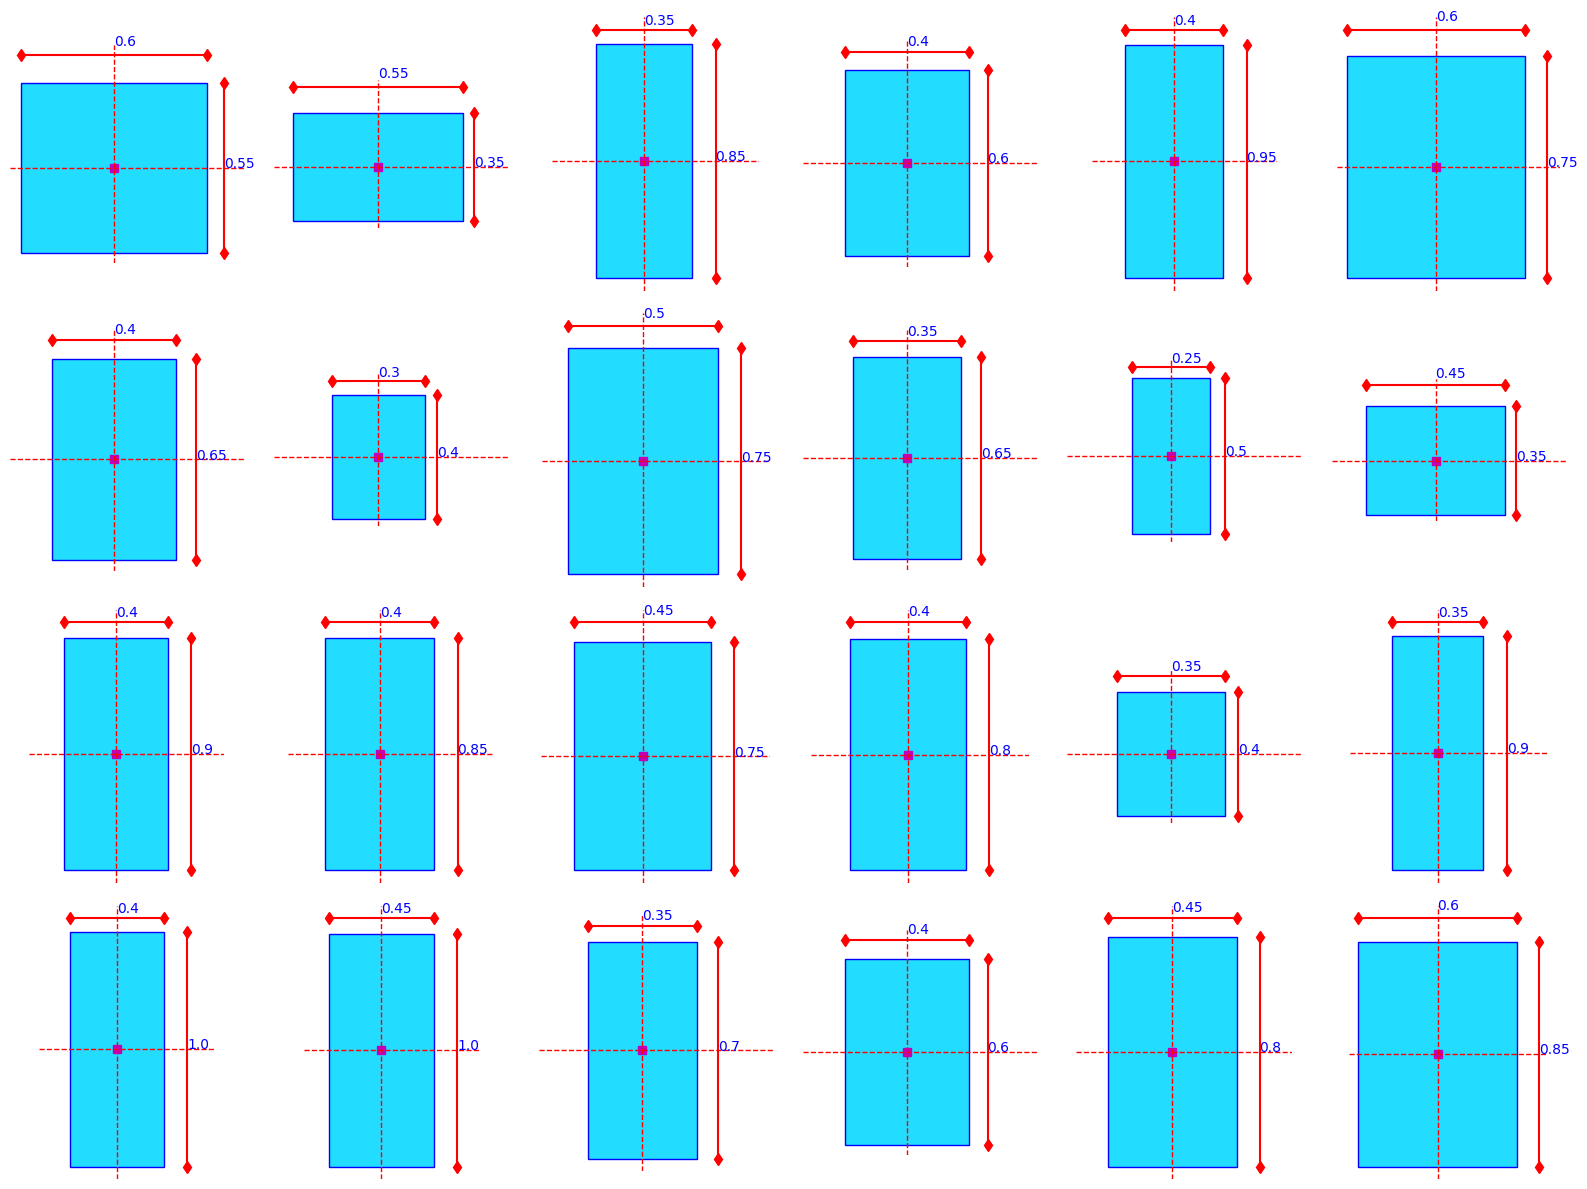

In [40]:
from func.seccionR import sec_rectangular

num_data = len(data['L'].head(24)) # debe ser multiplo de 6

fig, axes = plt.subplots(int(num_data/6), 6, figsize=(16, 12), sharex=True)
axs = axes.flatten() # lo convierte en una lista unidimensional
# fig.suptitle(f"Seccion de las vigas para {len(data)} muestras")

# sec_rectangular(axs[0], 2, 4, False)
for i in range(num_data):
    b = data['b'][i].item()
    h = data['h'][i].item()
    sec_rectangular(axs[i], round(b,2), round(h,2), False)
    axs[i].axis('scaled')
    # axs[i].set_ylabel("z")
    # axs[i].set_xlabel("y")
    
    axs[i].axis('off')
plt.box(False)
plt.tight_layout()
plt.show()

In [41]:
data.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
L,15000.0,6.01,2.30,2.00,4.00,6.00,8.00,10.00
b,15000.0,0.42,0.10,0.25,0.35,0.45,0.50,0.60
h,15000.0,0.65,0.20,0.30,0.45,0.65,0.80,1.00
P,15000.0,54.82,26.01,10.01,32.30,54.61,77.51,99.98
fc,15000.0,286.10,89.15,175.00,210.00,280.00,350.00,420.00
E,15000.0,24831531.87,3932056.86,19663000.00,21541000.00,24870000.00,27805000.00,30463000.00
I,15000.0,0.01,0.01,0.00,0.00,0.01,0.02,0.05
deflexion_max_mm,15000.0,3.31,7.45,0.00,0.26,0.91,2.95,182.00


In [42]:
data_keys = data.drop(columns=['E', 'I'], axis=1)
data_keys = data_keys.keys()
data_keys

Index(['L', 'b', 'h', 'P', 'fc', 'deflexion_max_mm'], dtype='object')

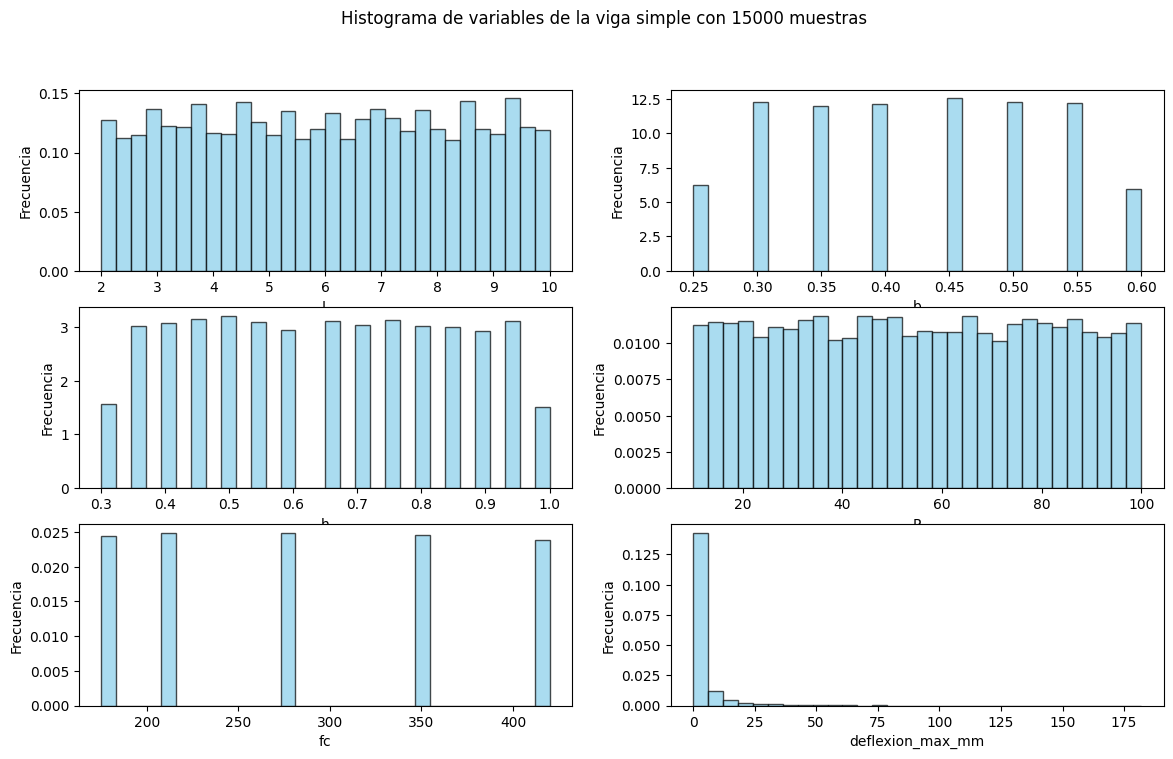

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
axs = ax.flatten() # lo convierte en una lista unidimensional
# print(axs)
fig.suptitle(f"Histograma de variables de la viga simple con {len(data)} muestras")

for i, var in enumerate(data_keys):
    axs[i].hist( data[var], bins=30, edgecolor='black', color="skyblue", density=True, alpha=0.7) # , kde=True
    # sns.histplot(data[column], kde=True, stat="count", bins=30, color='skyblue', edgecolor='black', ax=axes[i])
    # sns.kdeplot(data[column], color='red', ax=axes[i])
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("Frecuencia")
plt.tight_layout
plt.show()

 Analisis univariado con Función de densidad de probabilidad (PDF)  y Funciona de probabilidad acumulada (CDF)

,0,1,2,3
0,0.052925,0.963200,0.002641,0.963200
1,0.001440,0.026200,18.202074,0.989400
2,0.000396,0.007200,36.401508,0.996600
3,0.000114,0.002067,54.600941,0.998667
4,0.000051,0.000933,72.800374,0.999600
5,0.000015,0.000267,90.999807,0.999867
6,0.000000,0.000000,109.199240,0.999867
7,0.000000,0.000000,127.398673,0.999867
8,0.000004,0.000067,145.598106,0.999933
9,0.000004,0.000067,163.797539,1.000000


Text(0.5, 0, 'deflexion_max_mm')

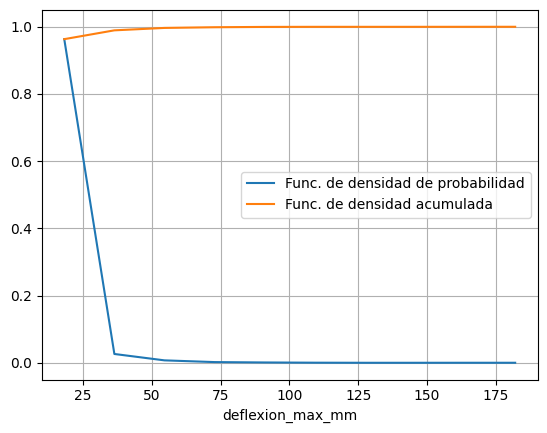

In [44]:
target = 'deflexion_max_mm'

counts, bin_edges = np.histogram(data[target],bins = 10, density = True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)

display( pd.DataFrame( [counts, pdf, bin_edges, cdf]).transpose() )

plt.plot(bin_edges[1:], pdf, label='Func. de densidad de probabilidad')
plt.plot(bin_edges[1:], cdf, label='Func. de densidad acumulada')
plt.legend() # 'cumulative distribution function'
plt.grid(True)
plt.xlabel(target)

### 🟢2. Entrenamento - Modelo de regresion

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Metricas para evaluar modelo de regresion

Raiz del error cuadratico medio.

$$RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\widehat{y_i})^2}$$

Error Absoluto medio
$$MAE=\frac{1}{n}\sum_{i=1}^{n}|y_{i}-\widehat{y_i}^2|$$


Coeficiente de Determinación ($R^2$)

$$R^2 = 1- \frac{\sum_{i=1}^{n}(y_{i}-\widehat{y_i})^2}{\sum_{i=1}^{n}(y_{i}-\overline{y_i})^2}$$


| Métrica | Ideal | Lo que te puede indicar 
|----------|----------|----------
|RMSE|cercano a cero| Cuanto se devia el modelo|
|MAE|Cercano a cero| Promedio del error absoluto|
|👉$R^2$|Cercano a uno| Corelacion positiva para un modelo de regresion Linial

In [46]:
data_keys2 = data.drop(columns=['I', 'deflexion_max_mm'], axis=1)
data_keys2 = data_keys2.keys()
data_keys2

Index(['L', 'b', 'h', 'P', 'fc', 'E'], dtype='object')

In [ ]:
X = data[data_keys2]
y = data['deflexion_max_mm']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% para la prueba y el 80 para el entrenamiento, con 42 de semilla para replicar

modelo = RandomForestRegressor(
    n_estimators=100, # 100 árboles
    max_depth=20, # numero máximo de niveles en cada árbol
    random_state=42 # para reproducibilidad
    )
display(modelo)
print(cross_val_score(modelo, X, y, cv=5))


modelo.fit(x_train, y_train) # entrenar el modelo

[0.95789062 0.97142266 0.9729311  0.9447929  0.9725157 ]


RandomForestRegressor(max_depth=20, random_state=42)

In [48]:
r_squared_score = modelo.score(x_test, y_test)
y_pred = modelo.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = np.mean(np.abs(y_test - y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

display(pd.DataFrame({
    'Real': y_test,
    'Predicción': y_pred
}).head(10))

print(f"RMSE: {rmse:.3f} mm")
print(f"MAE: {mae:.3f} mm")
print(f"R^2: {r2:.4f} - {r_squared_score==r2}")

,Real,Predicción
11499,0.592053,0.734843
6475,0.737542,0.700721
13167,1.978184,2.268831
862,0.138602,0.159521
5970,0.263565,0.234728
6706,16.739539,15.585839
3017,0.551970,0.622496
3781,0.601115,0.731933
3898,2.171065,2.288981
2250,0.176731,0.216343


RMSE: 1.240 mm
MAE: 0.367 mm
R^2: 0.9739 - True


In [49]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 12))
# plot_tree(modelo.estimators_[0],
#           feature_names=data_keys2,
#           filled=True,
#           rounded=True,
#           fontsize=10)
# plt.title("Árbol de Regresión")
# plt.show()

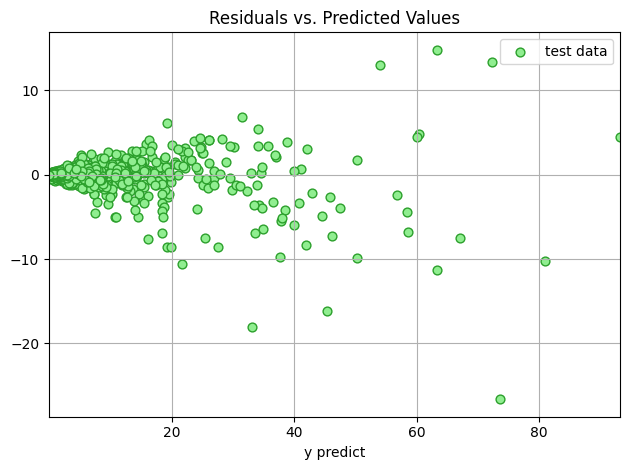

In [50]:
labels = y_test
predictions = y_pred
x_max = np.max(
    [np.max(y_pred), np.max(y_pred)]
)
x_min = np.min(
    [np.min(y_pred), np.min(y_pred)]
)

fig, axes = plt.subplots(nrows=1, ncols=1)

axes.set_title("Residuals vs. Predicted Values")
axes.scatter(y_pred, y_pred-y_test, color='lightgreen', marker='o', s=40, edgecolors='tab:green', label='test data')
axes.grid(True)
axes.set_xlabel('y predict')
axes.set_xlim([x_min, x_max])
axes.legend()

plt.tight_layout()
plt.show()

In [51]:
# modelo_dtr = DecisionTreeRegressor(
#     max_depth=20, # numero máximo de niveles en cada árbol
#     )
# modelo.fit(x_train, y_train) # entrenar el modelo

In [52]:
# tree_scores = cross_val_score(modelo, x_train, y_train, cv=5, n_jobs=20)

# # x_train_pred = modelo_dtr.predict(x_train)
# # y_test_pred = modelo_dtr.predict(y_test)

### 🟢 4. Visualizacion del modelo

In [53]:
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test, 
    y=y_pred, 
    mode='markers', 
    name='Predicciones',
    marker=dict(color='blue', size=5)
))
fig.add_trace(go.Scatter(
    x=y_test, 
    y=y_test, 
    mode='lines', 
    name='Línea de referencia',
    line=dict(color='red', width=2)
))
fig.update_layout(
    title='Predicciones vs Valores Reales',
    xaxis_title='Valores Reales (mm)',
    yaxis_title='Predicciones (mm)',
    width=800,
    height=600
)
fig.show()

In [54]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.scatter(y_test, y_pred, alpha=0.5)
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
# ax.set_xlabel('Valores Reales (mm)')
# ax.set_ylabel('Predicciones (mm)')
# ax.set_title('Valores Reales vs Predicciones')
# plt.grid()
# plt.tight_layout()
# plt.show()

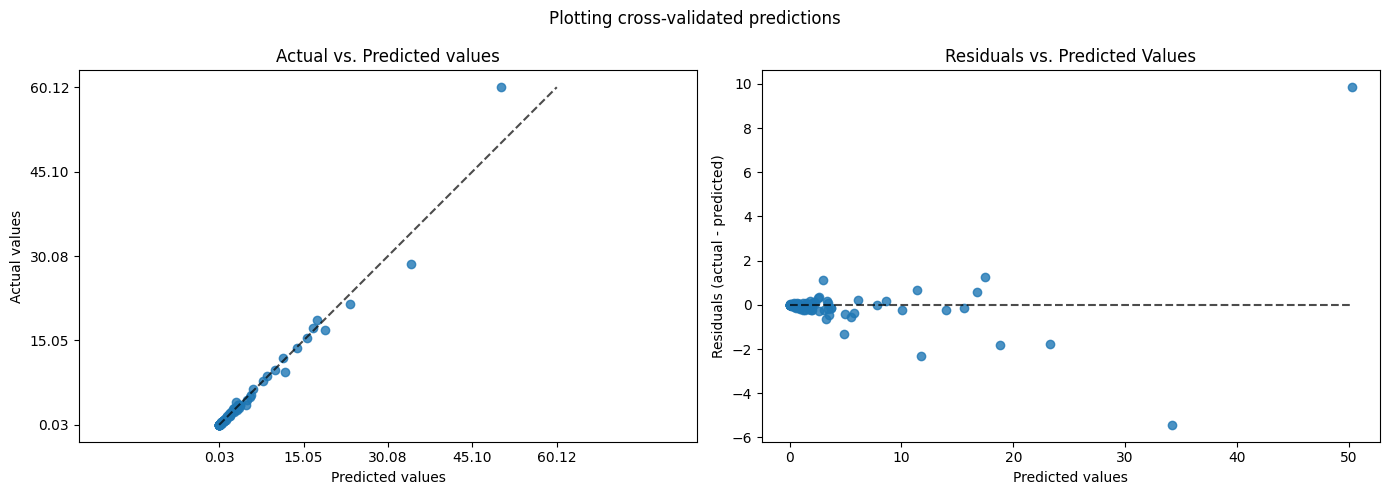

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

### 🟢 5. Comparativa

In [56]:
def predece_y_compara(datos_viga, modelo):
    data_in = pd.DataFrame([datos_viga])[data_keys2]

    pred_ml = modelo.predict(data_in)[0]

    # Calculo teorico
    longitud = datos_viga['L']
    carga = datos_viga['P']  # Convertir a N
    ancho_b = datos_viga['b']
    altura_h = datos_viga['h']
    E = datos_viga['E']
    I = (ancho_b * altura_h**3) / 12.0  # [m^4]
    deflexion_teorico = (carga * longitud**3) / (48 * E * I) # [mm]

    error = abs(pred_ml - deflexion_teorico)
    error_relativo = error / deflexion_teorico * 1000

    print(f"Cálculo Teorico ......: {deflexion_teorico:.2f} mm")
    print(f"Cálculo por ML: {pred_ml:.2f} mm")
    print(f"Error: {error:.4f} ({error_relativo:.2f}%)")

    return 0


In [57]:
datos_viga = {
    "L": 2.0 * (m),
    "P": 50.0 * (kN),
    "b": 0.30 * (m),
    "h": 0.50 * (m),
    "fc": 280 * (kg/cm**2),
    "E": 24_870_000 * (m**2),
}

response = predece_y_compara(datos_viga, modelo)
response

Cálculo Teorico ......: 0.11 mm
Cálculo por ML: 0.27 mm
Error: 0.1663 (1551.35%)


0

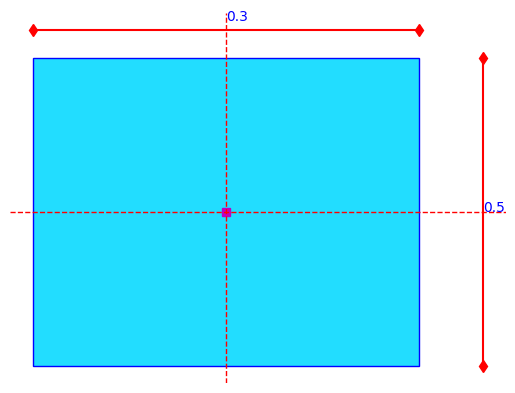

In [58]:
fig, axes = plt.subplots()
sec_rectangular(axes, datos_viga['b'], datos_viga['h'], False)
plt.axis('off')
plt.show()
plt.close()